# DEFINE GOOGLE COLAB FLAG!

In [1]:
isGoogleColab = False

# Notes

- check these blog posts: https://muellerzr.github.io/fastblog/ and his course: https://walkwithfastai.com/intro.contribute
- learner.export() already save all the transforms that will be applied during inference time, so it is not necessary to resize or normalize stats. If running outside the model outside fastai, check: https://forums.fast.ai/t/do-we-need-to-normalize-single-image-before-running-predict-function-on-it/44301/4
- to_fp16() is mixed precision
- item_tfms already apply the resize before collating the images in a batch. So it is not necessary to do this manually
- aug_tfms will only be applied on train_dl. validation and test will not be affected
- test_dl is a testing dataloader that uses the same transforms as train_dl and valid_dl, but with new data
- check images cleaner in the future
- cross validation: check walkwithfastai video 3 or https://forums.fast.ai/t/is-it-possible-to-implement-cross-validation-in-fastai/44961/15



# Installation

## Kill all other GPU sessions

Run the first time this cell. Then, restart your session and run again the notebook without this code.

In [2]:
  #!kill -9 -1

## Update ipython/ipykernel (Colab)

The Colab session can fail when running the first time this cell. Just run it a second time.

In [3]:
# This magic cell should be put first in your colab notebook. 
# It'll automatically upgrade colab's really antique ipython/ipykernel to their 
# latest versions which are required for packages like ipyexperiments 
from packaging import version
import IPython, ipykernel
IPython.__version__
if version.parse(IPython.__version__) <= version.parse("5.5.0"):
    !pip install -q --upgrade ipython
    !pip install -q --upgrade ipykernel
    
    import os
    import signal
    os.kill(os.getpid(), signal.SIGTERM)
print(f"ipykernel=={ipykernel.__version__}")
print(f"IPython=={IPython.__version__}")

ipykernel==5.3.4
IPython==7.21.0


In [4]:
# new (large)
# !pip install ipyexperiments
# new (large)
# from ipyexperiments import IPyExperimentsPytorch
# exp = IPyExperimentsPytorch()

## Check GPU e CPU RAM

In [5]:
if isGoogleColab:
    
    import torch
    from pynvml import *
    nvmlInit()
    def log_mem():
        h = nvmlDeviceGetHandleByIndex(0)
        info = nvmlDeviceGetMemoryInfo(h)
        print(f'GPU total Memory    : {info.total}')
        print(f'GPU free Memory     : {info.free}')
        print(f'GPU Memory used     : {info.used}')
    torch.ones(1).to(0)
    log_mem()

## Mount the Google Drive to Google Colab

In [6]:
if isGoogleColab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    path_to_drive = "/content/drive/My Drive/Colab Notebooks/"
else:
    path_to_drive = "./"

## Install Deep Learning libraries

In [7]:
#  !pip uninstall fastai
#  !pip install fastai
#  !pip install wandb
#  !pip install fastinference

In [8]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
Pytorch: 1.7.1
Fastai: 2.2.7


# Train your model

In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.callback.wandb import *
import wandb
import torch
import torchvision
from PIL import Image


## Data

In [17]:
path = path_to_drive + 'dataset_v1_size512/' 
path_anno = path + 'gt/'
path_img = path + 'done/'

#funcao que pega a imagem de anotacoes correspondente, dado a imagem original de entrada
get_y_fn = lambda x : path_anno + '/' + f'{x.stem}_GT.png'

In [18]:
np.random.seed(2) #mesma semente para todas as vezes que executar

label_fnames = get_image_files(path_anno)
print(label_fnames[:3])
fnames = get_image_files(path_img)
print(fnames[:3])

[Path('dataset_v1_size512/gt/0_GT.png'), Path('dataset_v1_size512/gt/1004_GT.png'), Path('dataset_v1_size512/gt/1005_GT.png')]
[Path('dataset_v1_size512/done/0.jpg'), Path('dataset_v1_size512/done/1.jpg'), Path('dataset_v1_size512/done/10.jpg')]


In [19]:
codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')
codes = [code.split(": ")[1] for code in codes] #pega apenas o nome de cada classe e ignora o ID
len(codes)

117

<ipython-input-20-65e6c6164177>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


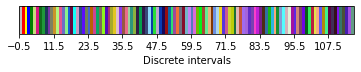

In [20]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) # nao alimento -> cinza
cmaplist[1] = "red" # nao registrado
cmaplist[2] = "yellow" #arroz integral
cmaplist[3] = "blue" #arroz branco
cmaplist[4] = "green" #feijao

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervalos devem conter apenas o numero inteiro, entao ir de 0.5 em 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

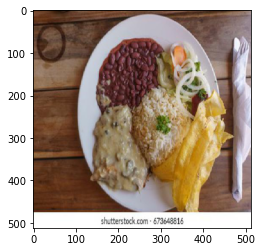

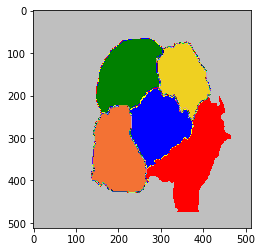

Ground truth Codes (array([ 0,  1,  3,  4, 55, 70], dtype=uint8), array([169307,  22992,  17006,  19310,  19310,  14219], dtype=int64))


In [21]:
### VISUALIZACAO DA MÁSCARA FICA COM A BORDA ESTRANHA, MAS ELA ESTÁ CORRETA COMO PODE SER VISTO NOS CODIGOS DO GROUND TRUTH

idx = 3

img = Image.open(fnames[idx])
arr = np.asarray(img)
plt.imshow(arr)
plt.show()

img1 = Image.open(get_y_fn(fnames[idx]))
arr = np.asarray(img1)
plt.imshow(arr, cmap=cmap, norm=norm)
plt.show()
print("Ground truth Codes",np.unique(arr,return_counts=True))


In [22]:
bs = 8 # batch size
sizeImage = (512,512) # Images should already come resized to fit in batches
print(sizeImage)

(512, 512)


## Data Augmentation

In [23]:
tfms = aug_transforms(pad_mode='zeros', mult=1, min_scale=1, flip_vert=True, size=sizeImage, max_warp=0.2)

## Dataloaders

In [24]:
dataloaders = SegmentationDataLoaders.from_label_func(path, bs=bs,
    fnames = fnames, 
    label_func = get_y_fn,                                     
    codes = codes,   
    valid_pct=0.3,
    seed=None,                
    batch_tfms=[*tfms, Normalize.from_stats(*imagenet_stats)])

dataloaders.vocab = codes


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [25]:
len(dataloaders.train_ds), len(dataloaders.valid_ds)

(356, 152)

C:\Users\bruno\miniconda3\lib\site-packages\fastai\torch_core.py:61: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.imshow(im, **kwargs)


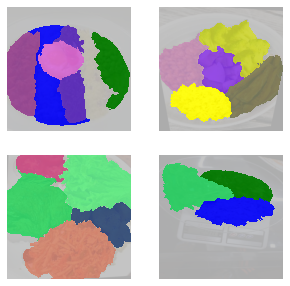

In [26]:
dataloaders.train.show_batch(max_n=4, figsize=(5, 5), cmap=cmap, norm=norm,alpha=0.9)

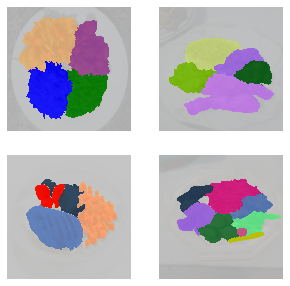

In [27]:
dataloaders.valid.show_batch(max_n=4, figsize=(5, 5), cmap=cmap, norm=norm,alpha=0.9)

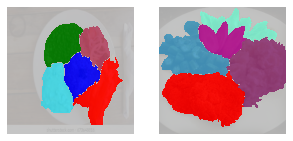

In [107]:
test_fnames = fnames[3:5]
test_dl = dataloaders.test_dl(test_fnames, with_labels=True)
test_dl.vocab = codes
test_dl.show_batch(max_n=4, figsize=(5, 5), cmap=cmap, norm=norm,alpha=0.9)

## Metrics

In [108]:
from fastaiMetrics import acc_segmentation, MIOU

classes_index = range(1, len(codes)) #exclude background class at index 0
metrics = [acc_segmentation, DiceMulti, MIOU(classes_index, axis=1)]

## Model

In [22]:
modelCallbacks = [ShowGraphCallback,EarlyStoppingCallback(patience=20)]
learner = unet_learner(dataloaders, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=metrics, cbs=modelCallbacks,
                       wd_bn_bias=True).to_fp16()

C:\Users\bruno\miniconda3\lib\site-packages\torch\cuda\amp\autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [ ]:
learner.model[0].load_state_dict(torch.load(path + 'resnet34_encoder-food101.h5'), strict=True); #load preTrained from FOOD101

In [ ]:
# learner.load(path + 'stage-2-brazilFoods', strict=False)
# learner.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# learner.model.load_state_dict(torch.load(path + 'stage-2-brazilFoods.pth'), strict=False)
# test = Learner(dataloaders,resnet34)
# test.model[0].

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:55: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


## Training

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=0.0002290867705596611)

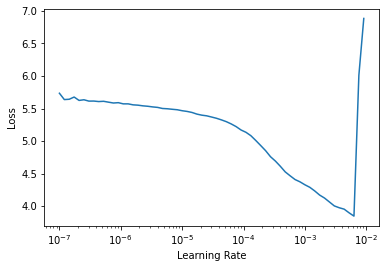

In [ ]:
learner.lr_find()

In [ ]:
lr = 2e-3
epochs = 100
wd = 1e-2
learner.freeze()

Better model found at epoch 0 with acc_segmentation value: 0.029962699860334396.


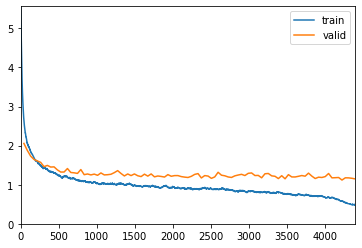

Better model found at epoch 1 with acc_segmentation value: 0.12327481806278229.
Better model found at epoch 2 with acc_segmentation value: 0.17371658980846405.
Better model found at epoch 3 with acc_segmentation value: 0.20594646036624908.
Better model found at epoch 4 with acc_segmentation value: 0.2303716242313385.
Better model found at epoch 6 with acc_segmentation value: 0.28942862153053284.
Better model found at epoch 8 with acc_segmentation value: 0.30520862340927124.
Better model found at epoch 10 with acc_segmentation value: 0.31493860483169556.
Better model found at epoch 11 with acc_segmentation value: 0.348404198884964.
Better model found at epoch 16 with acc_segmentation value: 0.36365997791290283.
Better model found at epoch 18 with acc_segmentation value: 0.37064841389656067.
Better model found at epoch 19 with acc_segmentation value: 0.3943151533603668.
Better model found at epoch 22 with acc_segmentation value: 0.4132751524448395.
Better model found at epoch 30 with acc

In [ ]:
wandb.init(project="diabetesLearning") # track machine learning experiment
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='acc_segmentation', fname='stage-1-best')]
learner.fit_one_cycle(epochs, slice(lr), pct_start=0.9, wd=wd, cbs=fitCallbacks)

## Fine-tunning

In [ ]:
# learner = unet_learner(dataloaders, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=metrics, cbs=callbacks,
#                        wd_bn_bias=True).to_fp16()
# learner.load('stage-1-best')


SuggestedLRs(lr_min=7.585775892948732e-06, lr_steep=7.585775847473997e-07)

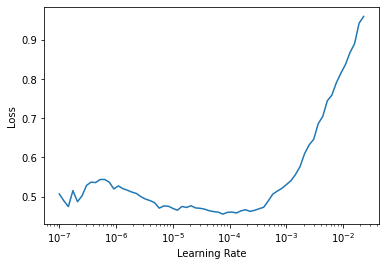

In [ ]:
learner.unfreeze()
learner.lr_find()

In [ ]:
lrs = slice(lr/400,lr/4)
epochs = 50
wd = 1e-2

Better model found at epoch 0 with acc_segmentation value: 0.5199917554855347.


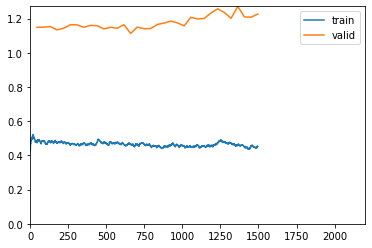

Better model found at epoch 3 with acc_segmentation value: 0.5212262272834778.
Better model found at epoch 10 with acc_segmentation value: 0.524182140827179.
Better model found at epoch 12 with acc_segmentation value: 0.5249100923538208.
Better model found at epoch 13 with acc_segmentation value: 0.5307233333587646.
Better model found at epoch 14 with acc_segmentation value: 0.5343295931816101.
Better model found at epoch 22 with acc_segmentation value: 0.5358467698097229.
No improvement since epoch 14: early stopping


In [ ]:
fitCallbacks = [WandbCallback(log='all'), SaveModelCallback(every_epoch=False, monitor='acc_segmentation', fname='stage-2-best')]
learner.fit_one_cycle(epochs, lrs, pct_start=0.8, wd=wd, cbs=fitCallbacks)

In [ ]:
# learner.load('stage-2-best')
# learner.save('stage-2-size350-bestEpoch')

## FastAI Validation

In [77]:
# LOAD ONLY IF NECESSARY
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id
learner = unet_learner(dataloaders, resnet34, metrics=metrics)
learner.load('stage-2-best')

C:\Users\bruno\miniconda3\lib\site-packages\fastai\learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [28]:
print(learner.validate(dl=test_dl))

C:\Users\bruno\miniconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=range(1, 117) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\Users\bruno\Documents\diabetesLearning\diabeteslearningDeeplearning\notebooks\tcc\fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)
C:\Users\bruno\miniconda3\lib\site-packages\fastai\torch_core.py:61: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  ax.imshow(im, **kwargs)


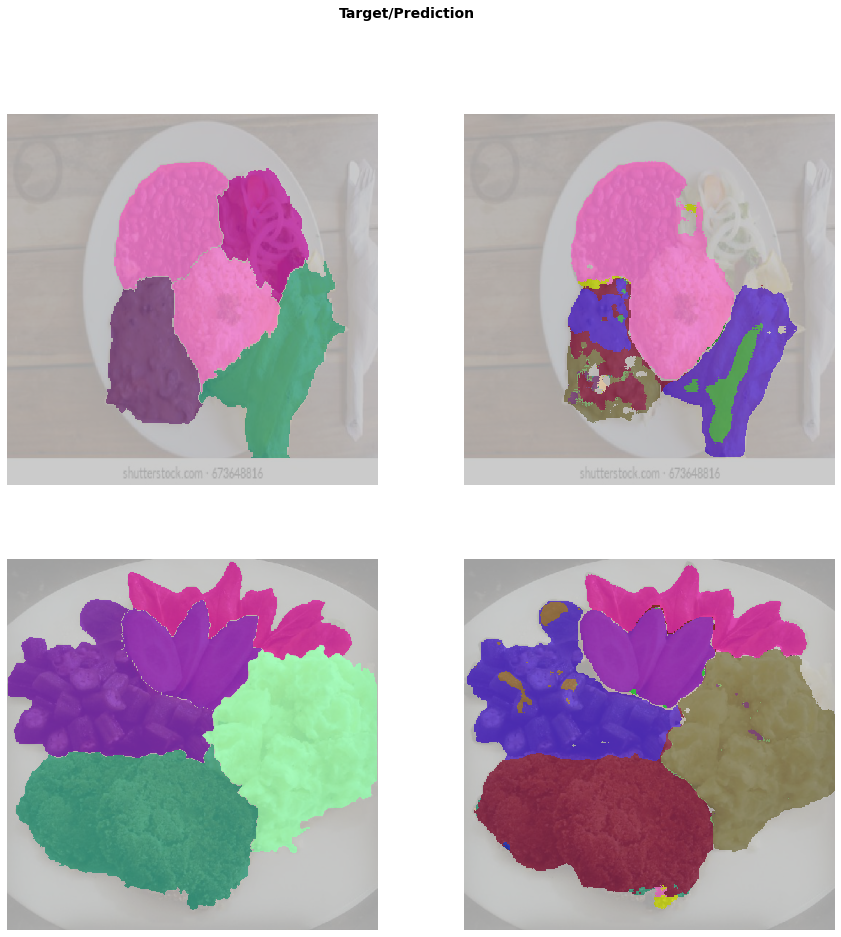

In [91]:
learner.show_results(dl=test_dl, figsize=(15,15), max_n=20, cmap=cmap, norm=norm,alpha=0.8)

In [34]:
interp = Interpretation.from_learner(learner, dl=test_dl)

In [78]:
losses,idxs = interp.top_losses()
interp.plot_top_losses(2, figsize=(15,11), cmap=cmap)

NameError: name 'interp' is not defined

In [31]:
#interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
#interp.most_confused(min_val=10)

## Sklearn Validation

In [31]:
from sklearnMetrics import Metrics
void_code = 0
metricsObject = Metrics(codes, [void_code])

# LOAD ONLY IF NECESSARY
id2name = {k:v for k,v in enumerate(codes)} # faz uma lista que relaciona nome e id
learner = unet_learner(dataloaders, resnet34, metrics=metrics)
learner.load('stage-2-best')

C:\Users\bruno\miniconda3\lib\site-packages\fastai\learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [32]:
input, probabilities, groundTruth, decoded, losses = learner.get_preds(dl=test_dl,  with_input=True, with_loss=True, with_decoded=True, act=F.softmax) #inputs, preds, groundTruth, losses

C:\Users\bruno\miniconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass labels=range(1, 117) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
c:\Users\bruno\Documents\diabetesLearning\diabeteslearningDeeplearning\notebooks\tcc\fastaiMetrics.py:39: RuntimeWarning: invalid value encountered in true_divide
  iou_index = per_class_TP / (per_class_TP + per_class_FP + per_class_FN)
C:\Users\bruno\miniconda3\lib\site-packages\torch\tensor.py:995: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ret = func(*args, **kwargs)


In [40]:
print(metricsObject.getAccuracy(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.26330192015004533


In [41]:
print(metricsObject.get_f1Score(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

0.27329683152320255


In [26]:
confusionMatrix = metricsObject.getConfusionMatrix(decoded.flatten().numpy(), groundTruth.flatten().numpy(), plot=False)

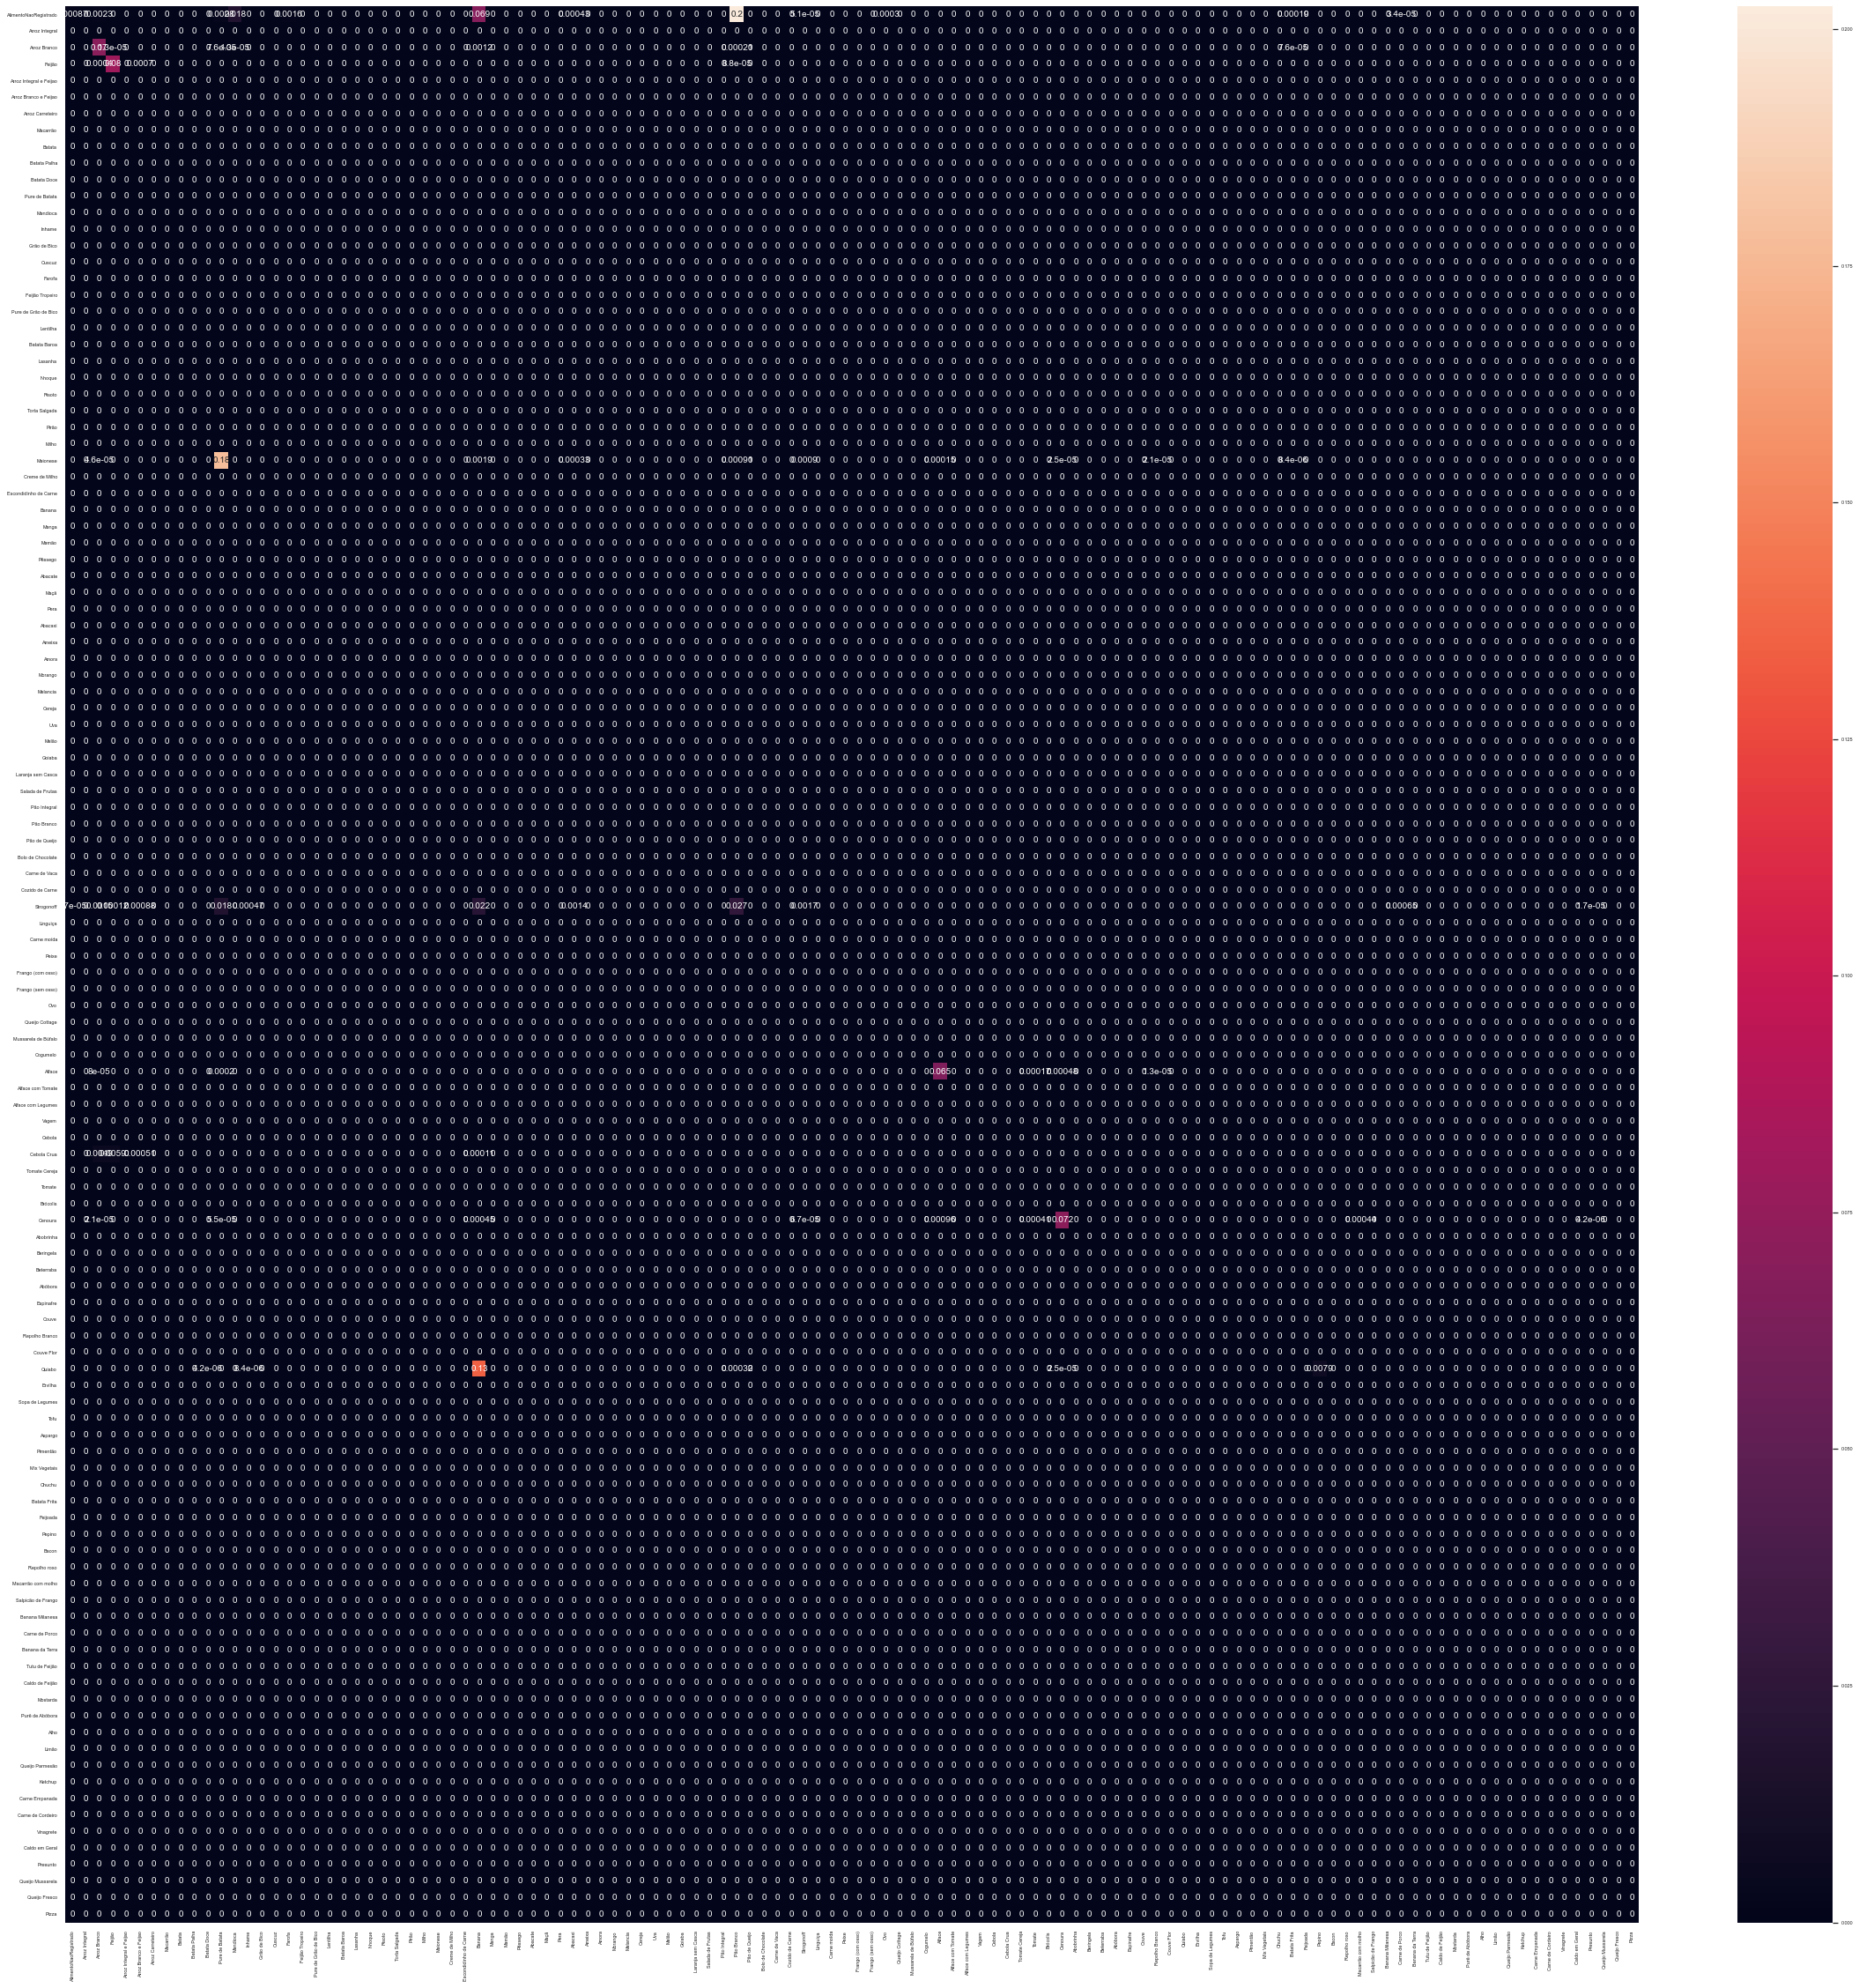

In [31]:
#plot confusion matrix (take some time, too big the matrix). Think in a better way to visualize (check for most confuseds)

metricsObject.plotConfusionMatrix(confusionMatrix, codes)

In [92]:
print(metricsObject.getClassificationReport(decoded.flatten().numpy(), groundTruth.flatten().numpy()))

                         precision    recall  f1-score   support

  AlimentoNaoRegistrado       0.69      0.00      0.01     74982
         Arroz Integral       1.00      1.00      1.00         0
           Arroz Branco       0.85      0.97      0.91     17006
                 Feijão       0.91      0.98      0.94     19310
Arroz Integral e Feijao       1.00      1.00      1.00         0
  Arroz Branco e Feijao       0.00      1.00      0.00         0
       Arroz Carreteiro       1.00      1.00      1.00         0
               Macarrão       1.00      1.00      1.00         0
                 Batata       1.00      1.00      1.00         0
           Batata Palha       1.00      1.00      1.00         0
            Batata Doce       0.00      1.00      0.00         0
         Pure de Batata       0.00      1.00      0.00         0
               Mandioca       0.00      1.00      0.00         0
                 Inhame       0.00      1.00      0.00         0
           Grão de Bico 

## Check some particular image details

In [33]:
from collections import OrderedDict

def getFoodsInImage(tensor, removeVoid=False):
    foods, counts = np.unique(tensor,return_counts=True)
    if removeVoid:
        counts = np.delete(counts, 0) #tira o void na posicao 0 do array
        foods = np.delete(foods, 0) #tira o void na posicao 0 do array
    
    foodNames = []
    print(f'Numero de alimentos: {len(foods)}')
    for food in foods:
        foodNames = np.append(foodNames,id2name[food])
    dictCounts = dict(zip(foodNames, counts))
    dictCounts = OrderedDict(sorted(dictCounts.items(), key=lambda x: x[1], reverse=True))
    print(dictCounts)
    return dictCounts

def getMostAppearances(foodCountsDict, k = 3):
    sortedDict = OrderedDict(sorted(foodCountsDict.items(), key=lambda x: x[1], reverse=True))
    topKDict = {}
    for count, (key, v) in enumerate(foodCountsDict.items()):
        if count == k:
            break
        elif key != "NaoAlimento":
            topKDict[key] = v
        else:
            k += 1 # increment k if find NaoAlimento in the first positions
    
    return topKDict
        


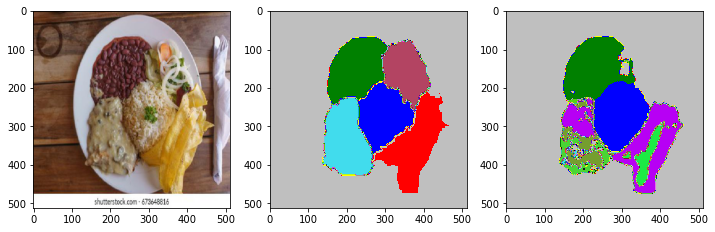

In [109]:
idx = 0
fig = plt.figure(figsize=(12,12))

# denorm to original image
rawImage = input[idx]
nrm = Normalize.from_stats(*imagenet_stats)
image = nrm.decode(rawImage).clamp(0,1).squeeze().permute(1,2,0) # denorm image from imagenet stats

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(image)

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(groundTruth[idx], cmap=cmap, norm=norm)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(decoded[idx], cmap=cmap, norm=norm)

In [88]:
print("Ground truth\n")
sample = groundTruth[idx]
gtDictCounts = getFoodsInImage(sample)


Ground truth

Numero de alimentos: 6
OrderedDict([('NaoAlimento', 169307), ('AlimentoNaoRegistrado', 22992), ('Feijão', 19310), ('Strogonoff', 19310), ('Arroz Branco', 17006), ('Cebola Crua', 14219)])


In [89]:
print("Prediction\n")
sample = decoded[idx]
decodedDictCounts = getFoodsInImage(sample)


Prediction

Numero de alimentos: 15
OrderedDict([('NaoAlimento', 183950), ('Banana', 21230), ('Feijão', 20712), ('Arroz Branco', 19162), ('Pão Branco', 6597), ('Pure de Batata', 4544), ('Mandioca', 4319), ('Arroz Branco e Feijao', 535), ('Strogonoff', 396), ('Abacaxi', 337), ('Carne de Porco', 154), ('Inhame', 112), ('Batata Frita', 76), ('AlimentoNaoRegistrado', 16), ('Presunto', 4)])


In [79]:
# get low prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)
lowProbs = []
lowProbsIdx = []

mask = bestProbs < 0.5
lowProbsIdx = bestProbsIdx[mask]
lowProbDictCounts = getFoodsInImage(lowProbsIdx)

print("\nPercentual de pixeis com baixa probabilidade\n")
for key, value in lowProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 15
OrderedDict([('Banana', 12089), ('Pão Branco', 5688), ('NaoAlimento', 5118), ('Pure de Batata', 4544), ('Mandioca', 4319), ('Feijão', 1711), ('Arroz Branco', 955), ('Arroz Branco e Feijao', 509), ('Strogonoff', 396), ('Abacaxi', 337), ('Carne de Porco', 154), ('Inhame', 112), ('Batata Frita', 76), ('AlimentoNaoRegistrado', 16), ('Presunto', 4)])

Percentual de pixeis com baixa probabilidade

Banana 56.94 %
Pão Branco 86.22 %
NaoAlimento 2.78 %
Pure de Batata 100.00 %
Mandioca 100.00 %
Feijão 8.26 %
Arroz Branco 4.98 %
Arroz Branco e Feijao 95.14 %
Strogonoff 100.00 %
Abacaxi 100.00 %
Carne de Porco 100.00 %
Inhame 100.00 %
Batata Frita 100.00 %
AlimentoNaoRegistrado 100.00 %
Presunto 100.00 %


In [80]:
# get high prob classes

bestProbs, bestProbsIdx = torch.max(probabilities[idx], dim=0)

mask = bestProbs > 0.5
highProbsIdx = bestProbsIdx[mask]
highProbDictCounts = getFoodsInImage(highProbsIdx)

print("\nPercentual de pixeis com alta probabilidade\n")
for key, value in highProbDictCounts.items():
    pct = float(value/decodedDictCounts[key]*100)
    print(key, '{:.2f}'.format(pct), "%" )

Numero de alimentos: 6
OrderedDict([('NaoAlimento', 178832), ('Feijão', 19001), ('Arroz Branco', 18207), ('Banana', 9141), ('Pão Branco', 909), ('Arroz Branco e Feijao', 26)])

Percentual de pixeis com alta probabilidade

NaoAlimento 97.22 %
Feijão 91.74 %
Arroz Branco 95.02 %
Banana 43.06 %
Pão Branco 13.78 %
Arroz Branco e Feijao 4.86 %


## Predictions of new input data

C:\Users\bruno\miniconda3\lib\site-packages\fastai\metrics.py:376: RuntimeWarning: Mean of empty slice
  return np.nanmean(binary_dice_scores)
Numero de alimentos: 16
OrderedDict([('NaoAlimento', 160121), ('Pure de Batata', 47347), ('Arroz Branco', 32620), ('Macarrão', 8212), ('Batata Palha', 8155), ('Strogonoff', 3325), ('Repolho Branco', 1114), ('Feijão', 771), ('Arroz Branco e Feijao', 342), ('Alface', 70), ('Pão Branco', 26), ('Arroz Integral', 15), ('Abacaxi', 14), ('Batata Frita', 6), ('Risoto', 5), ('AlimentoNaoRegistrado', 1)])

3 principais alimentos: ['Pure de Batata', 'Arroz Branco', 'Macarrão']


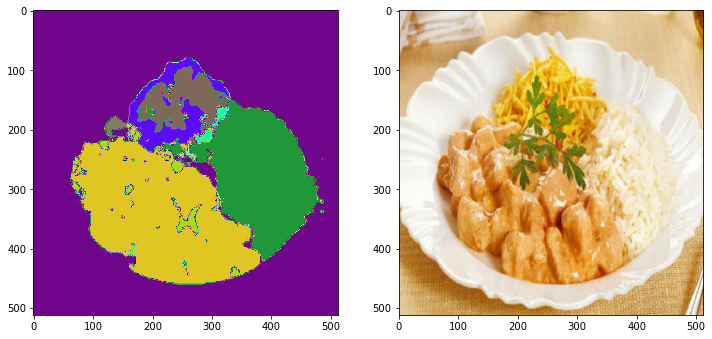

In [83]:
#input should be a PIL object

index = 2
pred = learner.predict(dataloaders.valid_ds[index][0])

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(pred[0],cmap=cmap)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(dataloaders.valid_ds[index][0])

foods = getFoodsInImage(pred[0])
k = 3
mostAppear = list(getMostAppearances(foods, k=k).keys())
print('\n{} principais alimentos:'.format(k),mostAppear)